In [18]:
# general packages and libraries
import os
import sys
from collections import defaultdict
import importlib

# data manipulation packages
import numpy as np
import pandas as pd

# data visualizations packages
import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

# numerical, statistical and machine learning packages and libraries
import xgboost as xgb
from scipy import stats

from sklearn import (
    ensemble,
    tree,
)
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin,
)
from sklearn.pipeline import (
    make_pipeline,
    FeatureUnion, 
    Pipeline,
)
from sklearn.feature_selection import (
    SelectKBest, 
    chi2, 
    mutual_info_classif,
    f_classif,
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer,
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder,
    StandardScaler,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
)

#from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import (
    SGDClassifier,
    LogisticRegression,
) 
from sklearn.metrics import (
    classification_report,
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix, precision_score,
    accuracy_score, recall_score,
    roc_auc_score,
    roc_curve, f1_score,
)



# Analysis of StackOverflow Survey

This notebook contains notes, alternate solutions and references for the project StackOverflow Developers' Survey 2020. It mainly concerns the modeling part which builds a multi-class classifier for the job satisfaction.

## Load the data

In [2]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df = pd.read_csv(mypath+'/data/survey20_updated.csv', index_col=[0])

# check the uploaded data
df.shape

(64461, 61)

In [3]:
# create a copy of the data
dft = df.copy()

## Remove unecessary data

### Keep the developers that work with data

- The column DevType is a multiple strings column.
- In the analysis we differentiate between data developers and other developers only.
- Data developers are: data scientist or machine learning specialist, data or business analyst, data engineer.

#### Method 1: create an auxiliary column DevClass

- Create a new column that marks if the developer works with data or not.
- Keep only those data points that correspond to data developers.

In [4]:
# these steps were performed in the initial stage of data preprocessing

# rename the data engineer string in the full dataset
#df['DevType'] = df['DevType'].str.replace('Engineer, data', 'Data engineer')

# respondents choose more than one answer as we can see below
# DevType_counts = df.DevType.value_counts().reset_index()

# create a list of the individual answers that can be marked by a user
#dev_choice = list(DevType_counts.devChoice.str.split(';', expand=True)[0].unique())

# the list of types of developers working with data
#data_dev = [x for x in dev_choice if 'Data ' in x]

# use np.where(condition, value if condition is true, value if condition is false)
# create column DevClass, entry data_coder or other_coder, based on DevType contains data or not
#df1['DevClass'] = np.where(df1["DevType"].str.contains("Data ", na = False), 'data_coder', 'other_coder')

# the subset of developers that checked at least one data related profession
#data_coders = df1[df1["DevClass"] == 'data_coder']

#### Method 2: split the strings and use pandas explode

- This creates rows duplicates, one for each choice of developer type.
- I suspect this method induces data leakage and eventually overfitting. 
- This method splits the developers in three categories, as above.

In [5]:
# change each string in DevType column into a list of strings
# this is necessary for pd.explode to work
#df1['DevType'] = df1['DevType'].str.split(';')

# split a row with multiple choices strings in DevType into rows where
# DevType contains only one choice, the index is replicated 
#df1=df1.explode('DevType')

# drop the rows with missing values in DevType column
# necessary for the string search in the next step to work
#df1.dropna(subset=['DevType'], inplace=True)

# retain only those rows that contain data coders
#df1 = df1[df1['DevType'].str.contains('Data ')]

In [ ]:
# keep the developers that work with data, use the custom function

# rewrite entries in 'DevType' column as strings to replicate rows
dft = uf.explode_col(dft, 'DevType')

# retain only those rows that contain data coders
dft = dft.loc[dft.DevType.str.contains('Data ', na=False)]

#### Method 3: split the strings in DevType and create corresponding columns

- Split each string in the entries of DevType.
- Create sparse column for each developer type.
- Retain only those data points that correspond to one of the data developers.

In [6]:
# source: https://github.com/adrianhasse/job-satisfaction

def handle_multi_string_columns(df, column, single_strings):
    '''
    Replaces column whose fields contain several strings with new columns. Each
    new column will then represent a single string
    
    INPUT:
    df - the pandas dataframe you want to search
    column - the column name you want to look through
    single_strings - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - The dataframe without the multi-string column but with the newly created columns
    col_dict - Dictionary translating names of the new columns to their corresponding string
    '''
    
    #collects new columns of indicating if a certain index refers to a string 
    new_columns = dict()
    
    #dict column name -> string name
    col_dict = dict()
    
    #loop through list of strings
    counter = 0
    for string in single_strings:
        bool_list = []
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row set to True
            if string in str(df[column][idx]):
                bool_list.append(1)
            else:
                bool_list.append(0)
        col_name = column + "_" + str(counter)
        new_columns[col_name] = bool_list
        col_dict[col_name] = string
        counter = counter + 1
    
    new_df = df.drop(column,axis=1)
    
    new_df = pd.concat([new_df, pd.DataFrame(data=new_columns, index = df.index, dtype=int)], axis=1)
    
    return new_df, col_dict

In [5]:
class StringtoSetTransformer(BaseEstimator, TransformerMixin):
    """Scikit-learn transformer to convert the feature which is a string with fields separated by comma into a column
    of a list"""
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            # if nan, create an empty set instead of imputation
            X[feature] = X[feature].str.split(';').apply(lambda x: {} if
                                                         x is np.nan else set(x))
        return X
    

class ListColumnsEncoder(BaseEstimator, TransformerMixin):
    """Scikit-learn transformer to convert a feature column of a list in 
    to multiple binary feature columns"""
    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # persist mode in a dictionary
        self.encoder_dict_ = {}
        
        for feature in self.variables:
            _ = MultiLabelBinarizer()
            _.fit(X[feature])
            self.encoder_dict_[feature] = _

    def transform(self, X):

        X = X.copy()
        for feature in self.variables:
            f_encoded = pd.DataFrame(
                self.encoder_dict_[feature].transform(X[feature]),
                columns=self.encoder_dict_[feature].classes_,
                index=X.index)

            X = pd.concat([X, f_encoded], axis=1).drop(columns=[feature])
        return X

In [ ]:
# MY APPROACH WITHOUT CLASSES

# replace the list of entries with sets, missing values with empy set
df1['PlatformWorkedWith'] = df1['PlatformWorkedWith'].str.split(';').apply(lambda x: {} if

# check the outcome                                                                      x is np.nan else set(x))
df1['PlatformWorkedWith'][:6]

# create an instance of the encoder
mlb = MultiLabelBinarizer()

# fit the binarizer and encode the selected column
temp_col = mlb.fit_transform(df1['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_df = pd.DataFrame(temp_col, columns=mlb.classes_, index=df1.index)

# combine the two dataframes and drop the initial column
df1 = pd.concat([df1, temp_df], axis=1).drop(columns = ['PlatformWorkedWith'])

# check the outcome
df1.shape

## Feature selection

Various ways to perform feature selection. Not included in the final approach.

In [5]:
# https://github.com/Chancylin/StackOverflow_Survey/blob/main/code/data_process.py

def cal_mutual_info(df, target_var=None, disc_features_only=True):
    """Calculate mutual information for feature selection, based on mutual_info_classif from sklearn.feature_selection.
    :param df: Pandas dataframe
    :param target_var: target variable
    :param disc_features_only: boolean, calculate mutual information for discrete feature only
    :return:
        a Pandas dataframe with mutual information for features
    """
    df = df.copy()

    df_f_type = df.dtypes
    df_f_type = df_f_type.loc[~df_f_type.index.isin([target_var])].copy()
    cols_if_num = df_f_type.apply(lambda x: np.issubdtype(x, np.number))
    discrete_f = ~cols_if_num
    # get all categorical features
    cols_num = cols_if_num[cols_if_num].index.tolist()
    cols_cat = cols_if_num[~cols_if_num].index.tolist()

    for col_cat in cols_cat:
        df[col_cat] = df[col_cat].fillna('Missing')

    for col_num in cols_num:
        df[col_num] = df[col_num].fillna(df[col_num].mean())
        
    enc = OrdinalEncoder()
    df[cols_cat] = enc.fit_transform(df[cols_cat])
    enc = OrdinalEncoder()
    df.loc[:, target_var] = enc.fit_transform(df[[target_var]])

    if not disc_features_only:
        all_features = df_f_type.index.tolist()
        mutual_info = mutual_info_classif(df[all_features], df[target_var].values,
                                          discrete_features=discrete_f,
                                          n_neighbors=20,
                                          random_state=123)
        df_mutual_info = pd.DataFrame(data=zip(all_features, mutual_info),
                                      columns=['columns', 'mutual_info'])
        return df_mutual_info
    else:

        mutual_info = mutual_info_classif(df[cols_cat], df[target_var].values,
                                          discrete_features=True)
        df_mutual_info = pd.DataFrame(data=zip(cols_cat, mutual_info),
                                      columns=['columns', 'mutual_info'])
        return df_mutual_info


### My approach: step_by_step

In [6]:
# the list of numerical columns
num_cols = df1.select_dtypes(include='float64').columns.to_list()
print(num_cols)

['Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs']


In [7]:
# the list of categorical columns, drop the target 'JobSat'
cat_cols = df1.select_dtypes(include='object').columns.to_list()
print(cat_cols)

['MainBranch', 'Hobbyist', 'Age1stCode', 'CompFreq', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'CollabToolsDesireNextYear', 'CollabToolsWorkedWith', 'DevOps', 'DevOpsImpt', 'EdImpt', 'JobHunt', 'JobHuntResearch', 'Learn', 'OffTopic', 'OnboardGood', 'OtherComms', 'Overtime', 'PurchaseResearch', 'PurpleLink', 'SOSites', 'Stuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'YearsCode', 'YearsCodePro', 'DevClass']


In [8]:
# the list of columns with high cardinality - will get a high selection score
multiple = ['DatabaseDesireNextYear', 'DatabaseWorkedWith', 
           'LanguageDesireNextYear', 'LanguageWorkedWith',
            'MiscTechDesireNextYear', 'MiscTechWorkedWith', 
            'CollabToolsDesireNextYear', 'CollabToolsWorkedWith', 
            'PlatformDesireNextYear', 'PlatformWorkedWith', 
            'WebframeDesireNextYear', 'WebframeWorkedWith']

In [9]:
# remove target 'JobSat' and the multiple columns from cat_cols
cat_cols = list(set(cat_cols) - set(multiple))
cat_cols.remove('JobSat')
print(cat_cols)

['OnboardGood', 'WelcomeChange', 'Ethnicity', 'JobHunt', 'OffTopic', 'SOPartFreq', 'Country', 'SOComm', 'MainBranch', 'SurveyLength', 'CompFreq', 'YearsCode', 'DevClass', 'Gender', 'JobHuntResearch', 'DevOps', 'Overtime', 'OtherComms', 'Age1stCode', 'EdImpt', 'YearsCodePro', 'SOVisitFreq', 'Trans', 'Learn', 'DevType', 'SOSites', 'Sexuality', 'PurpleLink', 'CurrencyDesc', 'SurveyEase', 'PurchaseResearch', 'JobFactors', 'Employment', 'Stuck', 'CurrencySymbol', 'OpSys', 'Hobbyist', 'OrgSize', 'UndergradMajor', 'SOAccount', 'EdLevel', 'JobSeek', 'PurchaseWhat', 'DevOpsImpt']


In [10]:
# drop all missing entries in 'JobSat'
df1.dropna(subset=['JobSat'], inplace=True)
# check output
df1['JobSat'].isnull().sum()

0

In [11]:
# fill in 'missing' in all categorical columns in the list
for col in cat_cols:
        df1[col] = df1[col].fillna('missing')
# check outcome
df1.isnull().sum()

MainBranch          0
Hobbyist            0
Age              8839
Age1stCode          0
CompFreq            0
                 ... 
WelcomeChange       0
WorkWeekHrs      4137
YearsCode           0
YearsCodePro        0
DevClass            0
Length: 61, dtype: int64

In [12]:
# fill in 'median' in all numerical columns in the list
for col in num_cols:
        df1[col] = df1[col].fillna(df1[col].median())
# check outcome
df1[num_cols].isnull().sum()

Age              0
CompTotal        0
ConvertedComp    0
WorkWeekHrs      0
dtype: int64

In [14]:
# scale the numerical columns

# create an instance of the scaler
scaler = StandardScaler()

# scale the numerical variables, fit and transform on the straining set
df1[num_cols] = pd.DataFrame(scaler.fit_transform(df1[num_cols]), 
                                columns=df1[num_cols].columns)

In [15]:
# encode the categorical variables
enc = OrdinalEncoder()
df1[cat_cols] = enc.fit_transform(df1[cat_cols])
enc = OrdinalEncoder()
df1.loc[:, 'JobSat'] = enc.fit_transform(df1[['JobSat']])

In [16]:
# feature selection function, to be rewritten as a custom transformer class
def select_features(X_train, y_train, score_function, kval, no_cols):# add X_test
    """
    Function for feature selection for (discrete) variables.
    INPUT: X_train - input dataframe, must have only discrete or only continuous features, 
                     pre-processed by removing/imputing missing values and encoded
           y_train - target pd.series, pre-processed
           score_function - can be any of the score functions supported by SelectKBest
           kval = the number of best features to return, can be 'all'
           no_cols = number of columns to print
    OUTPUT: dataframe with two columns, one for the column names in X_train, 
            the second for the scores computed, sorted in decreasing order of the scores
            #variant: if transform of X_test set is performed, 
                      it also returns the transformed dataframe
    """
    # create an instance of the selector
    fs = SelectKBest(score_func=score_function, k=kval)
    # fit the selector on the train set and the train target values
    fs.fit(X_train, y_train)
    # transform the train set, it will have only the kbest columns
    X_train_r = fs.transform(X_train) 
    # transform the test set, it will have only the kbest columns
    #X_test_r = fs.transform(X_test) 
    # get column names for kbest columns
    cols_info = fs.get_support(indices=True)
    cols = X_train.iloc[:,cols_info].columns
    # put columns and their scores together in a dataframe
    frame_best = pd.DataFrame(data=zip(cols,fs.scores_), columns = ['cat_columns', 'kbest_scores'])
    return frame_best.sort_values(by='kbest_scores', ascending=False).head(no_cols)
    return X_r, frame_best

In [17]:
# test the above function - done without X_test
select_features(df1[cat_cols], df1['JobSat'], mutual_info_classif, 'all', 5)

,cat_columns,kbest_scores
41,JobSeek,0.101638
0,OnboardGood,0.030806
3,JobHunt,0.030312
6,Country,0.026406
28,CurrencyDesc,0.016943
34,CurrencySymbol,0.015994
42,PurchaseWhat,0.013272
2,Ethnicity,0.009715
18,Age1stCode,0.009144
17,OtherComms,0.008300


In [18]:
# alternate approach to feature selection, using mutual_info_classif
mutual_info = mutual_info_classif(df1[cat_cols], df1['JobSat'],
                                          discrete_features='auto',
                                          n_neighbors=3,
                                          copy=True,
                                          random_state=42)
df_mutual_info = pd.DataFrame(data=zip(cat_cols, mutual_info), columns=['columns', 'mutual_info'])

In [23]:
df_mutual_info.sort_values(by='mutual_info', ascending=False)[:5]

,columns,mutual_info
41,JobSeek,0.100693
3,JobHunt,0.031575
0,OnboardGood,0.030981
28,CurrencyDesc,0.020989
34,CurrencySymbol,0.020525
6,Country,0.016402
31,JobFactors,0.010464
30,PurchaseResearch,0.010394
2,Ethnicity,0.010051
42,PurchaseWhat,0.008045


## Binning continuous variables

Tried in the first version. The accuracy scores of the models are very low. Did not include in the final approach

### Create bins for the WorkWeekHrs column

In [ ]:
# create a copy of the data
df1 = df.copy()

# create the labels
cut_labels = ['less-10', '10-20', '20-30', '30-40', '40-50', 'more-50']

# define the bins 
m = df1.WorkWeekHrs.max()
cut_bins = [0, 10, 20, 30, 40, 50, m]

# create a new column which contains the new labels
df1['WorkWeek_Bins'] = pd.cut(df1['WorkWeekHrs'], bins=cut_bins, labels=cut_labels)

# check for success
df1['WorkWeek_Bins'].value_counts()

In [ ]:
# change the type of the newly created column
df1['WorkWeek_Bins'] = df1['WorkWeek_Bins'].astype('object')

In [ ]:
# drop the WorkWeekHrs column
df1.drop(columns = 'WorkWeekHrs', inplace=True);

### Create bins for the ConvertedComp column

In [ ]:
# we could use quantile, however I prefer custom bins here
cut_labels = ['less-10K', '10K-30K', '30K-50K', '50K-100K', '100K-200K', 'more-200K']

# define the bins 
m = df1.ConvertedComp.max()
cut_bins = [0, 10000, 30000, 50000, 100000, 200000, m]

# create a new column which contains the new labels
df1['Comp_Bins'] = pd.cut(df1['ConvertedComp'], bins=cut_bins, labels=cut_labels)

# change the type of the newly created column
df1['Comp_Bins'] = df1['Comp_Bins'].astype('object')

# drop the WorkWeekHrs column
df1.drop(columns = 'ConvertedComp', inplace=True);

### Create bins for the Age column

In [ ]:
# define the bin edges
cut_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80']

# define the bins 
m = df1.Age.max()
cut_bins = [0, 20, 30, 40, 50, 60, 70, 80, m]

# create a new column which contains the new labels
df1['Age_Bins'] = pd.cut(df1['Age'], bins=cut_bins, labels=cut_labels)

# change the type of the newly created column
df1['Age_Bins'] = df1['Age_Bins'].astype('object')

# drop the WorkWeekHrs column
df1.drop(columns = 'Age', inplace=True);

### Remove the rows that contain mostly missing values

In [ ]:
# keep only the rows with at least 10 non-NA values
df1.dropna(thresh=10)

# check the result
df1.shape

## Create features and target

Create a dataframe (X) with the features and a pandas series (y) that contains the labels.

In [ ]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
print(X.info(), len(y))

In [ ]:
# format all the fields as strings in the feature matrix
X = X.astype(str)

## Sample data

We will use $30 \%$ data for testing:

In [ ]:
# split the data in train and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

## Impute missing values

Now that we have test and train data, we can impute missing values on the training set, and use the trained imputer to fill in the test dataset. I will use the KNN imputer from sklearn.

In [ ]:
# create an instance of the imputer
#imputer = KNNImputer(n_neighbors=5)

# fit the imputer on the dataset
#X_train_trans = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

# check for success
#X_train_trans.isna().any()
from sklearn.impute import SimpleImputer
def impute_predictors(X_train, X_test):
    imputer = SimpleImputer(strategy='constant', fill_value='missing')
    imputer.fit(X_train)
    X_train_trans = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
    X_test_trans = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    return X_train_trans, X_test_trans

## Encode the data

The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the train and test datasets.

The function below named prepare_inputs() takes the input data for the train and test

Regarding the output data, the target, since it is already encoded as an integer with values from 0 to 5, no other encoding steps are needed at this point.

Alternative would be:

In [ ]:
# prepare target
def encode_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [ ]:
# encode the high cardinality columns
def encode_predictors(X_train, X_test):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(X_train)
    X_train_enc = pd.DataFrame(enc.transform(X_train))
    X_test_enc = pd.DataFrame(enc.transform(X_test))
    return X_train_enc, X_test_enc

# the high cardinality encoded features
X_train_multi_enc, X_test_multi_enc = encode_predictors(X_train_cat_imp[multi_cols], 
                                                        X_test_cat_imp[multi_cols])

In [ ]:
# create an instance of the custom transformer
#multi_encoder = uc.MultiColumnsEncoder(feature_names=multi_cols)

# fit and transform the training set
#df_temp = multi_encoder.fit_transform(X_train[multi_cols])

In [ ]:
# fit the binarizer on the train set
mlb_plat = mlb.fit(X_train['PlatformWorkedWith'])

# transform the corresponding column in the train set
mlb_plat_train =  mlb_plat.transform(X_train['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_train = pd.DataFrame(mlb_plat_train, columns = mlb_plat.classes_,
                         index = X_train.index)

# list the three most popular platforms to retain
platform_keep = list(temp_plat_train.sum().sort_values(ascending=False).head(3).index)

# combine the two dataframes and drop the initial column
X_train = pd.concat([X_train, temp_plat_train[platform_keep]],
                    axis=1).drop(columns = ['PlatformWorkedWith'])

# apply the same transformations to the test set
mlb_plat_test =  mlb_plat.transform(X_test['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_test = pd.DataFrame(mlb_plat_test, columns = mlb_plat.classes_,
                              index = X_test.index)

# combine the two dataframes and drop the initial column
X_test = pd.concat([X_test, temp_plat_test[platform_keep]], 
                   axis=1).drop(columns = ['PlatformWorkedWith'])

## Baseline model: K NearestNeighbors

In [ ]:
# create an instance of the classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# fit the classifier
knn_clf.fit(X_train_fs, y_train)

# predict output values
y_pred = knn_clf.predict(X_test_fs)

In [ ]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)
         

## Several other algorithms 

In [ ]:
from sklearn.svm import SVC

# create classifier instance
svm_clf = SVC(gamma="auto", random_state=42)
# fit the model
svm_clf.fit(X_train_fs, y_train)

In [ ]:
# predict on the test set
y_pred = svm_clf.predict(X_test_fs)

# test one value
y_test.iloc[20],  y_pred[20]

In [ ]:
some_digit_scores = svm_clf.decision_function(X_test_fs)
some_digit_scores[20]

In [ ]:
np.argmax(some_digit_scores[20])

In [ ]:
svm_clf.classes_

In [ ]:
y_test.values[0]

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, X_test_fs, y_test, cv=10, scoring="accuracy")

In [ ]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)
         

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_fs, y_train)
y_pred = ovr_clf.predict(X_test_fs)

In [ ]:
result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X_train_fs, y_train)
y_pred = sgd_clf.predict(X_test_fs)

In [ ]:
result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)

In [ ]:
for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, 
              RandomForestClassifier, SGDClassifier]:
    make_pipeline(StandardScaler(),model())
    classifier = model()
    kfold = model_selection.KFold(n_splits=10)
    classifier.fit(X_train_fs.toarray(), y_train)
    s = model_selection.cross_val_score(classifier, X_test_fs.toarray(),y_test, cv=kfold)
    #result2 = classification_report(y_test, y_pred, zero_division=0)
    #s = model_selection.cross_val_score(cls, X, y, cv=kfold)
    print(f"{model.__name__:22}  CV_Mean:" f"{s.mean():.3f} CV_STD: {s.std():.2f}")

In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, 
                            n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train_fs, y_train)

#report_best_scores(search.cv_results_, 1)

In [ ]:
search.cv_results_['mean_test_score']

In [ ]:
search.best_params_

In [ ]:
#from stack
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X_train_fs):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train_fs, y_train)
    
    y_pred = xgb_model.predict(X_test_fs)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))

In [ ]:
cls = RandomForestClassifier()
kfold = model_selection.KFold(n_splits=10)
s = model_selection.cross_val_score(cls, X,y, cv=kfold)

In [ ]:
cls_rf = RandomForestClassifier()
kfold = model_selection.KFold(n_splits=10)
cls_rf.fit(X_train, y_train)
y_pred = cls_rf.predict(X_test)
s = model_selection.cross_val_score(cls_rf, X_test,y_test, cv=kfold)

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X1_train, y1_train)
y1_pred = sgd_clf.predict(X1_test)

In [ ]:
# preprocess, split and process data
#preproc_df2 = uf.preprocess_data(df2)
X2_train, y2_train, X2_test, y2_test = uf.process_data(preproc_df2, 'JobSat')

In [ ]:
for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, 
              RandomForestClassifier, SGDClassifier]:
    make_pipeline(StandardScaler(),model())
    classifier = model()
    kfold = model_selection.KFold(n_splits=10)
    classifier.fit(X2, y2)
    s = model_selection.cross_val_score(classifier, X2,y2, cv=kfold)
    #result2 = classification_report(y_test, y_pred, zero_division=0)
    #s = model_selection.cross_val_score(cls, X, y, cv=kfold)
    print(f"{model.__name__:22}  CV_Mean:" f"{s.mean():.3f} CV_STD: {s.std():.2f}")

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X2_train, y2_train)
y2_pred = sgd_clf.predict(X2_test)

In [11]:
# import local modules 
import utils_functions as uf 
import utils_classes as uc
import local_maps as lm

# forces the interpreter to re-load the module
importlib.reload(uf);

# create a path string
mypath = os.getcwd()

In [4]:
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']
num_cols = ['ConvertedComp', 'WorkWeekHrs', 'YearsCode']
uni_cols = ['OrgSize', 'UndergradMajor', 'PurchaseWhat', 
            'OpSys', 'Learn', 'Overtime', 'OnboardGood', 
            'DevOps', 'DevOpsImpt', 'EdLevel', 'EdImpt', 'JobSeek']
all_keep = ['Linux', 'Windows', 'Docker', 'Github', 'Slack', 'Jira']

In [5]:
## refactor code: processing data

# the steps in the categorical pipeline for columns of low cardinality
uni_cat_pipeline = Pipeline( steps = [( 'unicat_selector', uc.FeatureSelector(uni_cols) ),
                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                  ( 'ordinal_encoder', OrdinalEncoder() ) ] )

# the steps in the categorical pipeline for columns of high cardinality
multi_cat_pipeline = Pipeline( steps = [( 'multicat_selector', uc.FeatureSelector(multi_cols) ),
                                  ( 'multi_encoder', uc.MultiColumnsEncoder(multi_cols) ) ] )

# the steps in the numerical pipeline     
num_pipeline = Pipeline( steps = [ ('num_selector', uc.FeatureSelector(num_cols) ),
                                  ('imputer', KNNImputer(n_neighbors=5) ),
                                  ( 'std_scaler', StandardScaler() ) ] )

# combine the numerical and the categorical pipelines
full_pipeline = FeatureUnion( transformer_list = [ ( 'unicat_pipeline', uni_cat_pipeline ), 
                                                  ( 'multicat_pipeline', multi_cat_pipeline ) ,
                                                 ( 'numerical_pipeline', num_pipeline )] )

In [6]:
# upload the pre-processed data
dfp = pd.read_csv(mypath+'/data/survey20_pprocessed.csv', index_col=[0])

In [7]:
# create a copy of the dataset
df = dfp.copy()

In [8]:
# create the predictors dataframe
X = df.drop(columns = 'JobSat')

# create the labels
y = df['JobSat']

# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (7260, 17) (7260,)
Test (3112, 17) (3112,)


In [9]:
# the full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_kn = Pipeline( steps = [( 'full_pipeline', full_pipeline),
                                  ('model', KNeighborsClassifier(n_neighbors = 5))])

# call fit on the pipeline
full_pipeline_kn.fit( X_train, y_train )

# predict with the pipeline
y_pred_kn = full_pipeline_kn.predict( X_test ) 

In [12]:
# evaluate performance metrics on the train set
perf_train_kn = pd.Series(uf.get_perf_metrics(full_pipeline_kn,
                                              X_train, y_train), 
                       index = lm.metrics_list)

# evaluate performance metrics on the test set
perf_test_kn = pd.Series(uf.get_perf_metrics(full_pipeline_kn,
                                             X_test, y_test), 
                         index = lm.metrics_list)

# combine performance metrics for the baseline model
perf_model_kn = pd.DataFrame.from_dict({'train': perf_train_kn,
                                        'test': perf_test_kn}).round(3)

In [16]:
# print evaluation metrics and results

print('Performance metrics comparison for KNeighbors:\n', perf_model_kn)

result1_kn = confusion_matrix(y_test, y_pred_kn)
print('\nKNeighbors Confusion Matrix for Test Set:')
print(result1_kn)

result2_kn = classification_report(y_test, y_pred_kn)
print('\nKNeighbors Classification Report for Test Set:')
print (result2_kn)

Performance metrics comparison for KNeighbors:
            train   test
accuracy   0.580  0.364
precision  0.554  0.315
recall     0.536  0.307
f1         0.543  0.309

KNeighbors Confusion Matrix for Test Set:
[[ 56  28  18  82  74]
 [ 35 143  41 138 129]
 [ 13  79  54 124 113]
 [ 49 155  84 393 240]
 [ 58 144  69 306 487]]

KNeighbors Classification Report for Test Set:
              precision    recall  f1-score   support

           1       0.27      0.22      0.24       258
           2       0.26      0.29      0.28       486
           3       0.20      0.14      0.17       383
           4       0.38      0.43      0.40       921
           5       0.47      0.46      0.46      1064

    accuracy                           0.36      3112
   macro avg       0.31      0.31      0.31      3112
weighted avg       0.36      0.36      0.36      3112



In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

#allows printing of all data in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [27]:
x_train = full_pipeline.fit_transform(X_train)

In [30]:
x_test = full_pipeline.fit_transform(X_test)

In [34]:
#evaluation - baselines
num_folds = 5
#seed = 7
scoring = 'accuracy'
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR 0.404132 0.012873 
LDA 0.403306 0.012896 
KNN 0.357438 0.009372 
CART 0.516667 0.001185 
NB 0.380028 0.011876 
SVM 0.405372 0.007257 


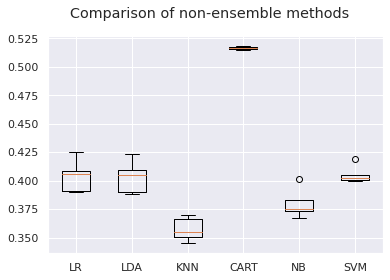

In [35]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Comparison of non-ensemble methods')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

In [ ]:
neighbors = [1, 3, 5, 7, 9, 15, 19, 21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))